In [1]:
# Libraries

!pip install ktrain
import ktrain
from ktrain import text

!python -m spacy download en_core_web_lg
import en_core_web_lg

import re
import os
import math
import string
import warnings
import itertools

from __future__ import print_function # Print each element on a separate line 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Flatten, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D

!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git
import preprocess_kgptalkie as kgp

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-yz71lna3
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-yz71lna3


In [2]:
# Set up parameters
warnings.filterwarnings('ignore')

plt.style.use('ggplot') # seanborn
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.figsize'] = [15,5]

pd.set_option('display.max_colwidth', None)

nlp = en_core_web_lg.load()

In [3]:
data_train = pd.read_excel('/content/traindataset_multiclassification.xlsm')

data_test  = pd.read_excel('/content/testdataset_multiclassification.xlsm')

# Exploring data

In [4]:
# Train dataset

print(f"train data shape: {data_train.shape}")
data_train.head(2)

train data shape: (8982, 2)


text  class
0  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3      3
1                                                                                                                 ? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3      4

In [5]:
# Test dataset

print(f"train data shape: {data_test.shape}")
data_test.head(1)

train data shape: (2246, 2)


id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text
0   1  ? the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to ? growth and expansion plans for ? inc and ? inc over the next two years a and p said the acquisition of ? in august 1986 and ? in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt ? ? of west germany reuter 3

In [6]:
# Number of classes
data_train['class'].value_counts().sort_index()

0       55
1      432
2       74
3     3159
4     1949
5       17
6       48
7       16
8      139
9      101
10     124
11     390
12      49
13     172
14      26
15      20
16     444
17      39
18      66
19     549
20     269
21     100
22      15
23      41
24      62
25      92
26      24
27      15
28      48
29      19
30      45
31      39
32      32
33      11
34      50
35      10
36      49
37      19
38      19
39      24
40      36
41      30
42      13
43      21
44      12
45      18
Name: class, dtype: int64

Text(0.5, 1.0, 'Number of examples per class')

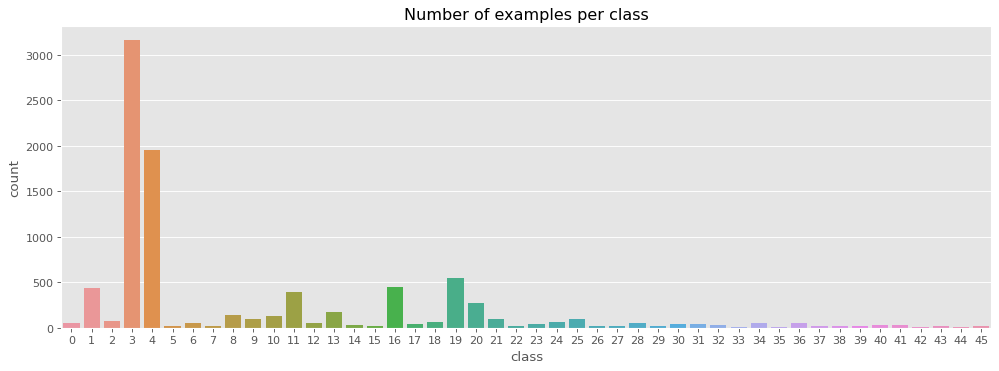

In [7]:
# Number of examples per class

plt.figure()
sns.countplot('class', data=data_train)
plt.title('Number of examples per class')

In [8]:
# Display some examples of a given label

def plot_per_class(df, label, usecol, nb=5):
    for text in data_train[data_train['class'] == label][usecol].head(nb):
        print(f"{text}\n")

plot_per_class(data_train, label=12, usecol='text')

? the u s civilian unemployment rate fell to 6 6 pct in march from 6 7 pct in february the labor department said the number of non farm payroll jobs rose 164 000 last month after rising a revised 236 000 in february that was down from the previously reported 337 000 rise in february the march unemployment rate was the lowest since march 1980 it had remained unchanged at 6 7 pct for three straight months before the march decline the rise in non farm ? was the smallest since a decline last june of 75 000 the department said last month's unemployment rate was down from the 7 2 pct level in march 1986 growth in jobs continued in march but was slower than in recent months with the gains concentrated in service industries the number of goods producing jobs fell 68 000 in march while service producing jobs rose 232 000 to bring the total jobs in the department's survey of businesses to 102 03 mln in march business and health services showed the largest gains in jobs while manufacturing employ

In [9]:
# Nan values
data_train.isna().sum()

text     0
class    0
dtype: int64

In [10]:
# Max, min, average length of the sequences

df_kgp = kgp.get_basic_features(data_train)

word_length = df_kgp[['class', 'word_counts']].groupby(['class']).sum()

word_length.max(), word_length.min(), word_length.mean()

(word_counts    276954
 dtype: int64, word_counts    1089
 dtype: int64, word_counts    28418.23913
 dtype: float64)

# Preprocessing


In [11]:
def preprocessing(df, usecols=[], nb=5, verbose=True, replace_col=True, lemmatiation=False):

    text_col = usecols[0] if replace_col else 'preprocessed_text'

    if verbose: 
        print(f"{df.columns}")
        print(f"DF before:\n{df.head(nb)}\n")
    
    non_charac, digits = set(), set()
    for x in df[usecols[0]]:
        non_charac |= set(re.findall(r'\W', x))   
        digits     |= set(re.findall(r'\d+\s*\d+', x))       

    # Remove the Non-alphanumeric
    if verbose: 
        print(f"Remove all these non-alphanumeric characters :\n{non_charac}")
    df[text_col] = df[usecols[0]].apply(lambda x: re.sub(r'\W', ' ', x))

    # Remove digits
    if verbose: 
        print(f"Remove all digits :\n{digits}")
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\d+\s*\d+', 'digit', x))
   
    # Lower case
    df[text_col] = df[text_col].apply(lambda x: x.lower())
   
    # Remove stopwords
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\b(' + \
                                                       r'|'.join(nlp.Defaults.stop_words) + \
                                                       r')\b', ' ', x))
   
    # Remove the months
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'january|february|march|april|' + 
                                                       r'may|june|july|august|september|' +
                                                       r'october|november|december',
                                                       'month', x))
   
    # Remove words with lenght 1,  2, 3 
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\b\w{1,3}\b', ' ',x))

    # Lemmatiation
    if lemmatiation:
        df[text_col] = df[text_col].apply(lambda x: ' '.join([word.lemma_ for word in nlp(x)]))
   
    # Remove the extra spaces at the middle, the beginning and the end of the text    
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\s+', ' ', x))        
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'(^\s+|\s+$)', ' ', x)) 

    # Remove duplicates 
    df[text_col] = df[text_col].apply(lambda x: re.sub(r'\b(\w+)( \1\b)+', r'\1', x))
    
    if verbose: 
        print(f"\n{df.columns}")
        print(f"DF after:\n{df[text_col].head(nb)}\n")

    # Shuffle the dataframe
    df = df.sample(frac=1)
    
    return df

In [12]:
df_train1 = preprocessing(data_train.copy(), usecols=['text'], nb=1, verbose=False, lemmatiation=False)

# Better to display the most frequent words with lemmatized words
df_train2 = preprocessing(data_train.copy(), usecols=['text'], nb=1, verbose=False, lemmatiation=True)

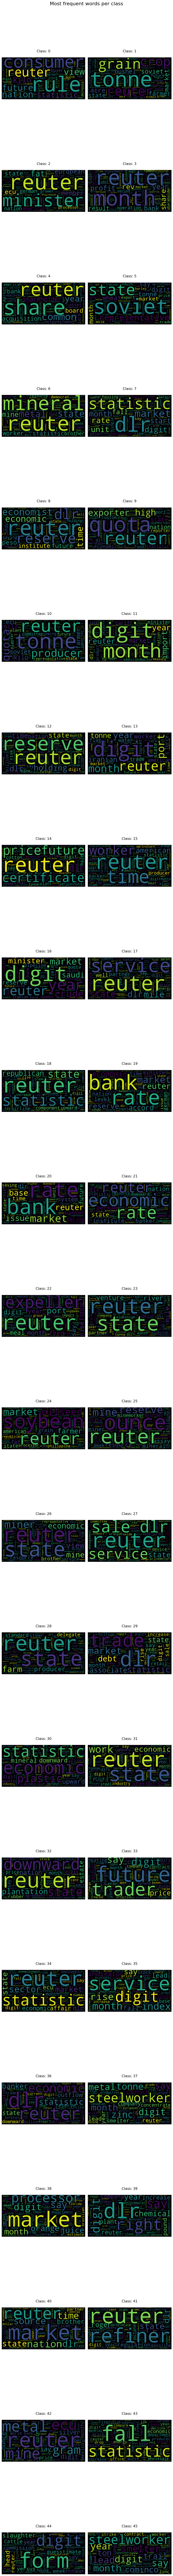

In [13]:
def plt_word_cloud(df, labelcol='class', textcol='text'):

    fig, axs = plt.subplots(nrows=23, ncols=2, figsize=(10, 150)) #, constrained_layout=True)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle('Most frequent words per class', fontsize=20, y=1)

    for label, ax in enumerate(axs.flat):
        words      = kgp.get_word_freqs(df[df[labelcol] == label], textcol)
        words      =  ' '.join(words.index)
        word_cloud = WordCloud(max_font_size=100).generate(words)
        ax.imshow(word_cloud, cmap='viridis')
        ax.set_title(f"Class: {label}\n")
        ax.axis('off')
        ax.grid(False)

    fig.tight_layout()
    plt.show()

plt_word_cloud(df=df_train2, labelcol='class', textcol='text')

In [17]:
# Checking the min, max, average length of the sequence, helps to choose a value for max_seq_len of our ML model

df_kgp = kgp.get_basic_features(df_train2)
word_length = df_kgp[['class', 'word_counts']].groupby(['class']).sum()

print(f"Max length  : {int(word_length.max())}\n" + \
      f"Min length  : {int(word_length.min())}\n" + \
      f"Mean length : {int(word_length.mean())}")

Max length  : 126339
Min length  : 531
Mean length : 13402


In [ ]:
# one hot encoding for the label isn't required for fasttext in our case (classes are disjoint)
#one_hot = pd.get_dummies(df_train["class"], drop_first=True)
#df_train = df_train.join(one_hot)
#df_train.head(1)

## Build the model using fastext

In [23]:
def evaluate_model(df, learner, preproc, train=True):
    """
    Evaluate the model
    Display the classification_report
    Display the confusion_matrix
    """

    predictor  = ktrain.get_predictor(learner.model, preproc)

    label  = predictor.predict(df['text'].tolist(), return_proba=False)
    proba  = predictor.predict(df['text'].tolist(), return_proba=True)
    if train:
        y_true = df['class'].tolist()
        y_pred = proba.argmax(1) 
        print(f"Accuracy : {(proba.argmax(1) == y_true).mean()}\n")

        clf_report = classification_report(y_true, proba.argmax(1))
        print(f"classification_report :\n{clf_report}\n")

        cnf_matrix = confusion_matrix(y_true, proba.argmax(1))
        print(f"confusion_matrix :\n{cnf_matrix}\n")

        sns.heatmap(cnf_matrix / cnf_matrix.sum(axis=1), center=0, cmap="YlGnBu")
    else:
        y_true = None
    
    return label, proba, y_true

In [19]:
def build_model(df, model='fasttext', usedcol='text', labelcol='class', 
                ngram_range=4, vocab_size=50000, max_seq_len=1000):
    
    train, val, preproc = text.texts_from_df(train_df=df, 
                                         text_column=usedcol, 
                                         label_columns=labelcol,
                                         ngram_range=ngram_range, 
                                         max_features=vocab_size, 
                                         maxlen=max_seq_len)
    
    model = text.text_classifier(model, train, preproc)

    
    # Get a learner
    learner = ktrain.get_learner(model, train, val)

    return model, learner, train, val, preproc

In [ ]:
model1, learner1, train1, val1, preproc1 = build_model(df=df_train1,
                                                       model='fasttext', 
                                                       usedcol='text', 
                                                       labelcol='class', 
                                                       ngram_range=2, 
                                                       vocab_size=50000, 
                                                       max_seq_len=800)

In [ ]:
learner1.autofit(0.001, epochs=100)

Accuracy : 0.9480071253618347

classification_report :
              precision    recall  f1-score   support

           0       0.96      0.84      0.89        55
           1       0.93      0.95      0.94       432
           2       0.92      0.99      0.95        74
           3       0.97      0.97      0.97      3159
           4       0.96      0.96      0.96      1949
           5       1.00      0.76      0.87        17
           6       0.98      1.00      0.99        48
           7       0.94      1.00      0.97        16
           8       0.87      0.90      0.88       139
           9       0.91      0.99      0.95       101
          10       0.92      0.94      0.93       124
          11       0.93      0.94      0.93       390
          12       0.98      0.88      0.92        49
          13       0.94      0.94      0.94       172
          14       0.85      0.88      0.87        26
          15       0.86      0.95      0.90        20
          16       0.94   

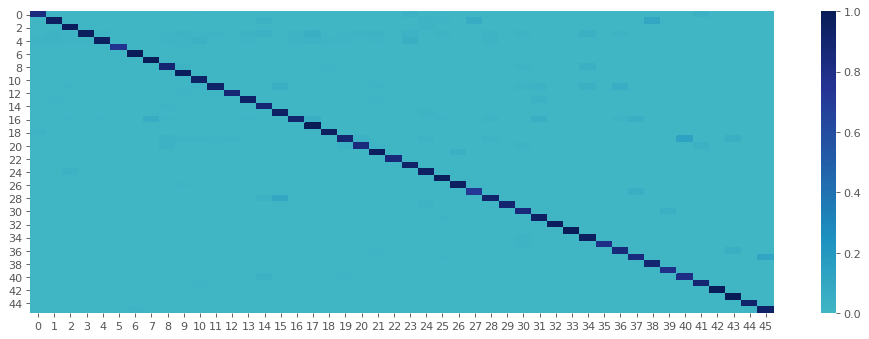

In [24]:
label_train1, proba_train1, y_true_train1 = evaluate_model(df_train1, learner1, preproc1)

# Evaluating the model

In [26]:
## Test challenge

df_test = preprocessing(data_test.copy(), usecols=['text'], nb=1, verbose=False, lemmatiation=False)

label_test, proba_test, y_true_test = evaluate_model(df_test, learner1, preproc1, train=False)

df_test['class'] = list(proba_test.argmax(1))

df_test.head(1)

id  ... class
829  830  ...    11

[1 rows x 3 columns]

In [28]:
df_test.to_csv("dataString.csv")